In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV


# Modeling
from xgboost import XGBRegressor
from xgboost import plot_importance

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

import warnings

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
index_to_save = 6

<IPython.core.display.Javascript object>

In [4]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [5]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "partner_i",
    "Features": "Chemical + Mineralogical + Feature Engineering",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "XGBoost",
    "Model Params": None,
    "Scaler": None,
    "Scaler Params": None,
    "Imputer": None,
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [6]:
df = pd.read_csv("../../../../../data/processed/partner_i-Oficial/cpiif40.csv")

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep all features

In [7]:
df_copy = df.drop(
    [
        # Properties
        "Blaine",
        "Initial setting time",
        "Final setting time",
        "Density",
        "#200",
        "#325",
        "CS3",
        "CS7",
        # Chemical Composition
        # Reason: Loss on Ignition is the only feature
        # that belongs to chemical composition in which was
        # measured by a different method, namely manual
        "LOI",
    ],
    axis=1,
).copy()

<IPython.core.display.Javascript object>

## Feature Engineering

In [8]:
# Feature Engineering over Chemical Features
ch_features = ["CaO", "MgO", "Na2O", "Al2O3", "SiO2", "SO3", "K2O", "Fe2O3"]

df_copy["std_ch_feats"] = df_copy[ch_features].std(ddof=0, axis=1)

df_copy["ratio_CaO_to_SiO2"] = df_copy["CaO"] / df_copy["SiO2"]
df_copy["ratio_MgO_to_CaO"] = df_copy["MgO"] / df_copy["CaO"]

# Feature Engineering over Mineralogical Features
mi_features_set1 = [
    "Belite alpha",
    "Belite beta",
    "Belite gamma",
    "Ferrite",
    "Aluminate",
    "Aluminate cubic",
    "Aluminate orto",
]

mi_features_set2 = [
    "Portlandite",
    "Periclase",
    "Arcanite",
    "Aphthalite",
    "Gypsum",
    "Bassanite",
    "Anhydrite",
    "Calcite",
    "Dolimite",
    "Quartz",
]
df_copy["mean_mi_set1_feats"] = df_copy[mi_features_set1].mean(axis=1)
df_copy["mean_mi_set2_feats"] = df_copy[mi_features_set2].mean(axis=1)

df_copy["ratio_Aluminate_to_Ferrite"] = df_copy["Aluminate"] / df_copy["Ferrite"]
df_copy["std_gypsum_and_%gypsum"] = df_copy[["Gypsum", "%Gypsum"]].std(ddof=0, axis=1)
df_copy["std_limestone_clinker"] = df_copy[["%Limestone", "%Clinker"]].std(
    ddof=0, axis=1
)

<IPython.core.display.Javascript object>

<h2>1. Dataset: df_copy</h2> <br>In this dataset all features are used.

In [9]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

# 1. XGBoost

In [10]:
PARAMS = {
    "objective": "reg:squarederror",
    "n_estimators": 5,
    "max_depth": 3,
    "random_state": SEED,
    "verbosity": 0,
    "silent": True,
}

<IPython.core.display.Javascript object>

## 1.1 Repeated KFold Cross validation

<b>Dataset shape:</b> (1234, 38)<br>
<b>Repeats:</b>10<br>
<b>Splits:</b>10<br>
    1. 10 folds of 123 samples each
    2. 90% train (1111 samples each fold)
    3. 10% test (123 samples each fold)
<b>Total:</b> 100 models<br>

In [11]:
repeats = 3
n_splits = 5
pipeline = Pipeline(
    [
        ("estimator", XGBRegressor(**PARAMS)),
    ]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Repeated KFold"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 3}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use is

Repeated Cross Validation:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -0.866 (0.021)
MAE: -0.682 (0.016)
MAPE: -0.014 (0.000)
R2: 0.461 (0.022)


******
[TEST]
******
RMSE: -1.025 (0.070)
MAE: -0.796 (0.049)
MAPE: -0.017 (0.001)
R2: 0.235 (0.062)




/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

<IPython.core.display.Javascript object>

## 1.2. Blocking Time Series Cross Validation

<b>Dataset shape:</b> (1234, 38)<br>
<b>Splits:</b>5<br>    
    1. 5 folds of 246 samples
    2. 50% train (123 samples each fold)
    3. 50% test (123 samples each fold)
<b>Total:</b> 5 models<br>

In [12]:
n_splits = 5
train_size = 0.8

pipeline = Pipeline(
    [
        ("estimator", XGBRegressor(**PARAMS)),
    ]
)
cv = BlockingTimeSeriesSplit(n_splits=n_splits, train_size=train_size)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
print("Blocking Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Blocking Time Series Split"
results_dict_copy[
    "Cross Validation Params"
] = '{"N_Splits": 5, "Repeats": 1, "train_size": 0.8}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Blocking Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -0.516 (0.038)
MAE: -0.408 (0.039)
MAPE: -0.009 (0.001)
R2: 0.779 (0.063)


******
[TEST]
******
RMSE: -1.062 (0.328)
MAE: -0.861 (0.300)
MAPE: -0.018 (0.006)
R2: -0.550 (0.728)




/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

<IPython.core.display.Javascript object>

## 1.3. Time Series Split Cross Validation

The training set has size i * n_samples // (n_splits + 1) + n_samples % (n_splits + 1) in the i th split, with a test set of size n_samples//(n_splits + 1) by default, where n_samples is the number of samples.


<b>Dataset shape:</b> (1234, 38)<br>
<b>Splits:</b>10<br>    
    1. Train: 10 folds of 114, 226, 338, 450, 562, 675, 787, 899, 1011, 1123 samples each fold
    2. Test: 112 samples each fold
<b>Total:</b> 10 models<br>

In [13]:
n_splits = 5
gap = 0
pipeline = Pipeline(
    [
        ("estimator", XGBRegressor(**PARAMS)),
    ]
)
cv = TimeSeriesSplit(gap=gap, max_train_size=None, n_splits=n_splits, test_size=None)

scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
print("Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Time Series Split"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 1, "Gap": 0}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -0.674 (0.112)
MAE: -0.528 (0.094)
MAPE: -0.011 (0.002)
R2: 0.594 (0.136)


******
[TEST]
******
RMSE: -1.114 (0.395)
MAE: -0.868 (0.299)
MAPE: -0.018 (0.006)
R2: -0.083 (0.175)




/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

<IPython.core.display.Javascript object>

## 1.4. Out of time Split Cross Validation

<b>Dataset shape:</b> (1234, 38)<br>
<b>Train size: 80%</b><br>
<b>Test  size: 20%</b>


<b>Splits:</b> 2<br>    
    1. Train: 987
    2. Test: 247
<b>Total:</b> 1 model<br>

In [14]:
test_size = 0.2

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=test_size, random_state=SEED, shuffle=False
)
pipeline = Pipeline(
    [
        ("estimator", XGBRegressor(**PARAMS)),
    ]
)

pipeline.fit(x_train, y_train)

y_train_pred = pipeline.predict(x_train)
y_test_pred = pipeline.predict(x_test)

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Out of time Split"
results_dict_copy["Cross Validation Params"] = '{"Test Size": 0.2}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(
    results_dict_copy, {key: [value] for key, value in scores.items()}
)
results_to_save.append(df_results)

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

******
[TRAIN]
******
RMSE: 0.813 (0.000)
MAE: 0.633 (0.000)
MAPE: 0.013 (0.000)
R2: 0.499 (0.000)


******
[TEST]
******
RMSE: 1.302 (0.000)
MAE: 0.993 (0.000)
MAPE: 0.021 (0.000)
R2: -0.014 (0.000)




/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

<IPython.core.display.Javascript object>

In [15]:
pd.concat(results_to_save).groupby(["Features", "Model", "Cross Validation"])[
    ["RMSE Test", "MAE Test", "MAPE Test", "R2 Test"]
].agg(
    ["mean", lambda series: pd.Series(series.std(ddof=0), name="std")]
).reset_index().rename(
    columns={"<lambda_0>": "std"}
)

Features    Model  \
                                                             
0  Chemical + Mineralogical + Feature Engineering  XGBoost   
1  Chemical + Mineralogical + Feature Engineering  XGBoost   
2  Chemical + Mineralogical + Feature Engineering  XGBoost   
3  Chemical + Mineralogical + Feature Engineering  XGBoost   

             Cross Validation RMSE Test            MAE Test            \
                                   mean       std      mean       std   
0  Blocking Time Series Split  1.061935  0.328267  0.861288  0.300148   
1           Out of time Split  1.302494  0.000000  0.993475  0.000000   
2              Repeated KFold  1.024913  0.070262  0.796355  0.049438   
3           Time Series Split  1.114384  0.394985  0.867947  0.298820   

  MAPE Test             R2 Test            
       mean       std      mean       std  
0  0.018098  0.006171 -0.549602  0.727822  
1  0.020615  0.000000 -0.014196  0.000000  
2  0.016662  0.000988  0.235042  0.062100  
3  0.018039  0.005825 -0.083212  0.175281

<IPython.core.display.Javascript object>

# Saving the results Dataframe

## Saving the full dataframe

In [16]:
path = "../../../../../reports/results/local_models/partner_i-oficial/cpiif40/full/"
filename = f"xgboost_results_full_{index_to_save}.csv"

pd.concat(results_to_save).to_csv(
    path_or_buf=path + filename,
    mode="w",
    index=False,
    header=True,
)

<IPython.core.display.Javascript object>

## Saving the grouped dataframe

In [17]:
cols_groupby = [
    "Category",
    "Company",
    "Data Shape",
    "Timesteps",
    "Features",
    "Model",
    "Cross Validation",
    "Cross Validation Params",
]

cols_agg = ["RMSE Train", "MAE Train", "MAPE Train", "R2 Train"] + [
    "RMSE Test",
    "MAE Test",
    "MAPE Test",
    "R2 Test",
]

path = "../../../../../reports/results/local_models/partner_i-oficial/cpiif40/grouped/"
filename = f"xgboost_results_grouped_{index_to_save}.csv"


df_results_to_save = (
    pd.concat(results_to_save)
    .groupby(cols_groupby, dropna=False)[cols_agg]
    .agg(["mean", lambda series: pd.Series(series.std(ddof=0), name="std")])
    .reset_index()
    .rename(columns={"<lambda_0>": "std"})
)

df_results_to_save.to_csv(
    path_or_buf=path + filename,
    mode="w",
    index=False,
    header=True,  # header=df_results_to_save.columns
)

<IPython.core.display.Javascript object>

In [18]:
model = pipeline.get_params()["steps"][0][1]
model.get_params()


{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 3,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 5,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 47,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': 0,
 'silent': True}

<IPython.core.display.Javascript object>

In [19]:
pipeline.get_params()["steps"][0][1]

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5, n_jobs=None,
             num_parallel_tree=None, random_state=47, ...)

<IPython.core.display.Javascript object>

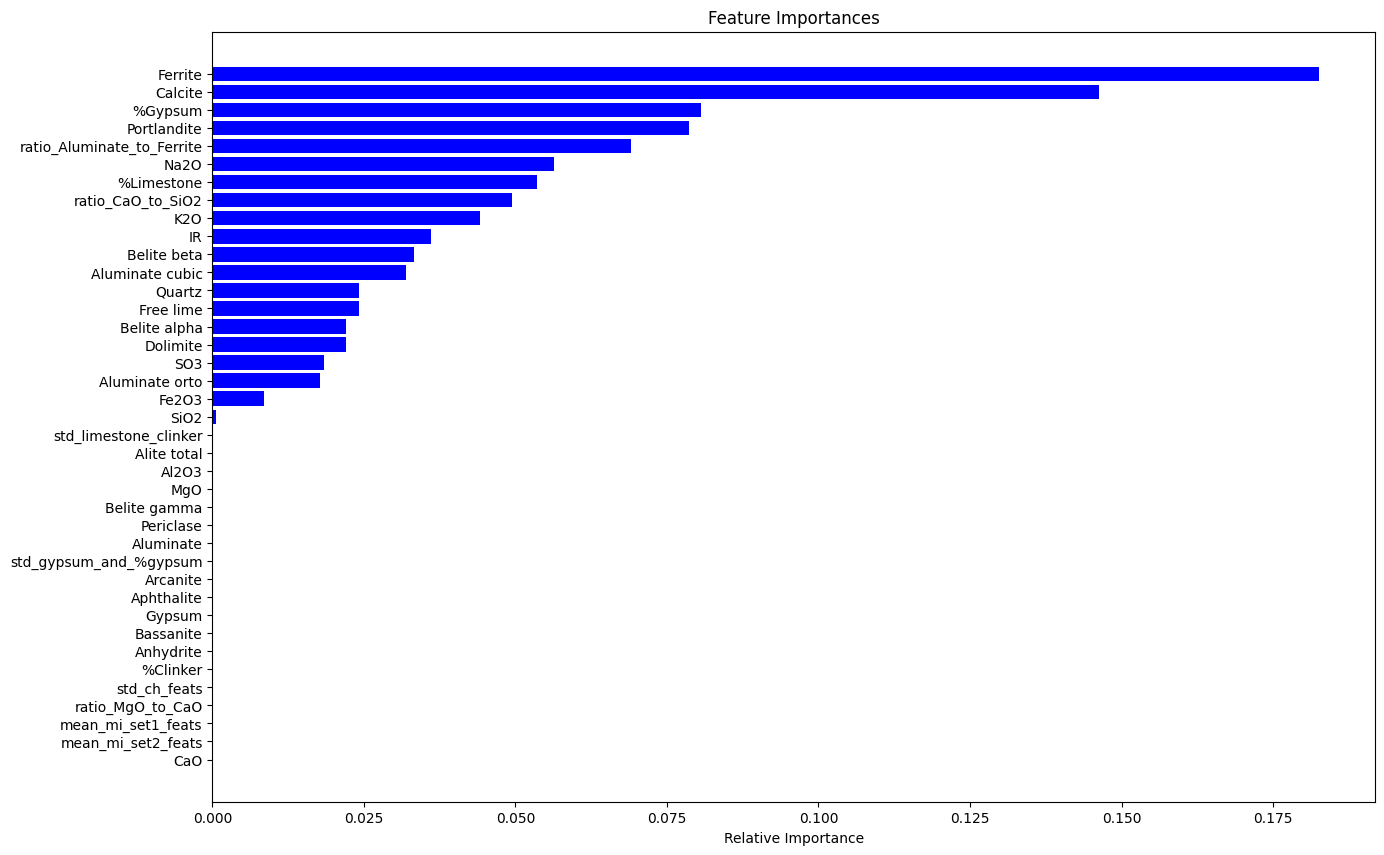

<IPython.core.display.Javascript object>

In [20]:
features = x.columns
importances = model.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="b", align="center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show(ax)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 1000x1000 with 0 Axes>

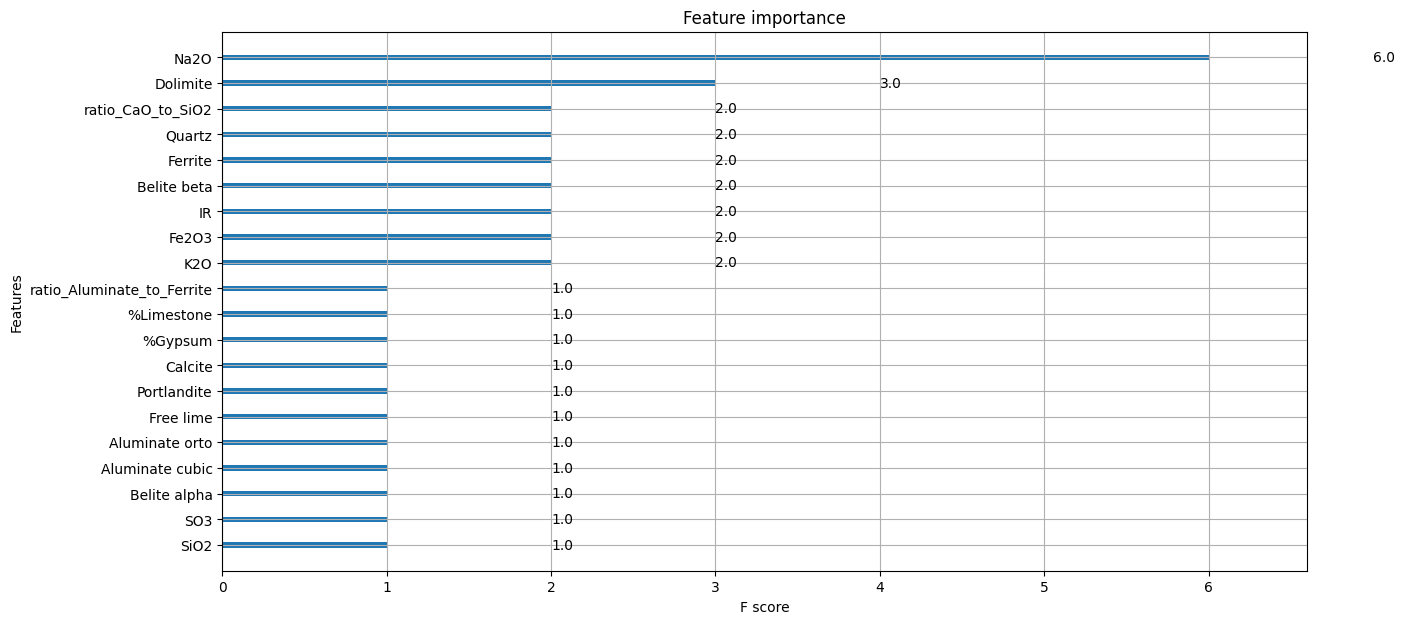

<IPython.core.display.Javascript object>

In [21]:
plt.figure(figsize=(10, 10))
plt.rcParams["figure.figsize"] = (14, 7)
plot_importance(model)

In [22]:
PARAMS

{'objective': 'reg:squarederror',
 'n_estimators': 5,
 'max_depth': 3,
 'random_state': 47,
 'verbosity': 0,
 'silent': True}

<IPython.core.display.Javascript object>